In [ ]:
%%capture capt
!pip install -r ../requirements.txt

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import pandas as pd
from tqdm import tqdm

import json
import yaml
import re

pd.set_option('future.no_silent_downcasting', True)

# DATA

## Load data and tokens

In [7]:
with open('../data/entities.json', 'r') as f:
    data = json.load(f)

In [8]:
with open('../data/tokens.yml', 'r') as f:
    tokens = yaml.safe_load(f)
    
token_to_col = {}
for col in tokens.keys():
    token = tokens[col]['start']
    token_to_col[token] = col

## Preprocessing

In [9]:
def blank_dict(tokens=tokens):
    d = {}
    for col in list(tokens.keys()):
        d[col] = None
    return d

def split_by_token(line, token_to_col=token_to_col):
    tokens_to_split = list(token_to_col.keys())
    pattern = '(' + '|'.join(re.escape(token) for token in tokens_to_split) + ')'
    
    splits = re.split(pattern, line)
    # Filter out empty strings and trim kept strings
    splits = [part.strip() for part in splits if part]
    return splits

def split_to_dict(split, token_to_col=token_to_col, dict_split=None):
    if dict_split is None:
        dict_split = blank_dict()
    for i in range(0, len(split), 2):
        token = split[i]
        element = split[i+1]
        column = token_to_col[token]
        dict_split[column] = element
    return dict_split

In [10]:
df_dict = {}
counter = 0
for key in tqdm(data.keys()): 
    for line in data[key].split('\n'):
        try:
            split = split_by_token(line)
            split_dict = split_to_dict(split)
            df_dict[counter] = split_dict
                    
            counter += 1
        except:
            pass

100%|██████████| 1218/1218 [00:00<00:00, 3351.74it/s]


In [11]:
df = pd.DataFrame().from_dict(df_dict, orient='index').fillna(value=np.nan)

indices_to_remove = []
for i in range(len(df)):
    if np.all(df.iloc[i].isna()):
        indices_to_remove.append(i)

df = df.loc[~df.index.isin(indices_to_remove)]

In [12]:
X = df.drop(columns=['surname_household'])
y = df['surname_household'].apply(
                                lambda x: 0 if pd.isna(x) else 1
                            )

In [13]:
X

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname
0,25,NaN,Garçon,NaN,NaN,Cyrille,NaN,NaN,NaN,française,NaN,menuisier,Breton
1,30,NaN,Garçon,NaN,NaN,Auguste,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN
2,24,NaN,Garçon,NaN,NaN,Pierre,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN
3,48,NaN,Homme marié,NaN,NaN,Alexandre,NaN,NaN,NaN,française,NaN,prop re,NaN
4,30,NaN,NaN,NaN,NaN,Zélie,sa fe,NaN,NaN,française,NaN,prop re,Vignat
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25433,NaN,1869,NaN,NaN,NaN,Marie,chef,Pailharès,NaN,idem,NaN,NaN,NaN
25434,NaN,1863,NaN,NaN,Cara,Marie,chef,St Naz en Royans,NaN,idem,NaN,ouv chaus res,NaN
25435,NaN,1886,NaN,NaN,Baretto,Nello,chef,Castel,NaN,italienne,NaN,manoeuvre,NaN
25436,NaN,1887,NaN,NaN,NaN,Annunziata,épouse,idem,NaN,idem,NaN,NaN,Berni-Laureti


# MODELLING

## Gradient Boosing

In [14]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import log_loss

### Ordinal Encoding

In [15]:
enc = OrdinalEncoder()
X_encoded = enc.fit_transform(X)

In [16]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.20, stratify=y)

### All information

In [13]:
param_grid = {
    "learning_rate": [1e-1, 1e-2, 1e-3],
    "max_leaf_nodes": [15, 31, 100],
    "max_depth": [None, 5, 10, 20],
    "min_samples_leaf": [10, 20, 50],
    "l2_regularization": [0.0, 0.1, 1.0]
}

model = HistGradientBoostingClassifier(max_iter=10_000, early_stopping=True, class_weight='balanced', validation_fraction=0.2)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=0)

grid_search.fit(X_train_enc, y_train_enc)

GridSearchCV(cv=3,
             estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                      early_stopping=True,
                                                      max_iter=10000,
                                                      validation_fraction=0.2),
             n_jobs=-1,
             param_grid={'l2_regularization': [0.0, 0.1, 1.0],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [None, 5, 10, 20],
                         'max_leaf_nodes': [15, 31, 100],
                         'min_samples_leaf': [10, 20, 50]},
             scoring='accuracy')

In [14]:
# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

Best parameters: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_depth': 20, 'max_leaf_nodes': 31, 'min_samples_leaf': 10}


In [15]:
# Get the best model from the grid search
clf = grid_search.best_estimator_

In [16]:
print(f"Train accuracy: {clf.score(X_train_enc, y_train_enc):.3f}")
print(f"Test accuracy: {clf.score(X_test_enc, y_test_enc):.3f}")

Train accuracy: 0.998
Test accuracy: 0.996


In [17]:
print(f'Train CE loss = {log_loss(y_train_enc, clf.predict_proba(X_train_enc)):.4f}')
print(f'Test CE loss = {log_loss(y_test_enc, clf.predict_proba(X_test_enc)):.4f}')

Train CE loss = 0.0058
Test CE loss = 0.0115


### Remove surname

There seems to be a direct inverse correlation between the presence of the surname and being a household leader, in the sense that a household leader has a household surname given but has no surname, and vice versa for non household leaders. Hence, it might be to easy for the model as it only has to check whether there is a surname or not to predict the truth. <br>
Hence, we remove this column of information from the training data to see if the model is still able to have great results with the remaining information.

In [17]:
enc = OrdinalEncoder()
X_encoded_no_surname = enc.fit_transform(X.drop(columns=['surname']))

In [18]:
X_train_enc_no_surname, X_test_enc_no_surname, y_train_enc_no_surname, y_test_enc_no_surname = train_test_split(X_encoded_no_surname, y, test_size=0.20, stratify=y)

In [20]:
model = HistGradientBoostingClassifier(max_iter=10_000, early_stopping=True, class_weight='balanced', validation_fraction=0.2)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=0)

grid_search.fit(X_train_enc_no_surname, y_train_enc_no_surname)

GridSearchCV(cv=3,
             estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                      early_stopping=True,
                                                      max_iter=10000,
                                                      validation_fraction=0.2),
             n_jobs=-1,
             param_grid={'l2_regularization': [0.0, 0.1, 1.0],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [None, 5, 10, 20],
                         'max_leaf_nodes': [15, 31, 100],
                         'min_samples_leaf': [10, 20, 50]},
             scoring='accuracy')

In [21]:
# Print the best parameters found
print("Best parameters while not using surname:", grid_search.best_params_)

Best parameters while not using surname: {'l2_regularization': 1.0, 'learning_rate': 0.1, 'max_depth': 20, 'max_leaf_nodes': 100, 'min_samples_leaf': 10}


In [22]:
# Get the best model from the grid search
clf_no_surname = grid_search.best_estimator_
clf_no_surname.fit(X_train_enc_no_surname, y_train_enc_no_surname);

In [23]:
print(f"Train accuracy no surname: {clf_no_surname.score(X_train_enc_no_surname, y_train_enc_no_surname):.3f}")
print(f"Test accuracy no surname: {clf_no_surname.score(X_test_enc_no_surname, y_test_enc_no_surname):.3f}")

Train accuracy no surname: 0.940
Test accuracy no surname: 0.926


In [24]:
print(f'Train CE loss no surname = {log_loss(y_train_enc_no_surname, clf_no_surname.predict_proba(X_train_enc_no_surname)):.4f}')
print(f'Test CE loss no surname = {log_loss(y_test_enc_no_surname, clf_no_surname.predict_proba(X_test_enc_no_surname)):.4f}')

Train CE loss no surname = 0.1519
Test CE loss no surname = 0.2020


## Fine-Tune pretrained model

In [67]:
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

### Preprocessing & load model

In [68]:
# Regroup every element in a row into a string, dropping the emppty elements

X_str = np.array([' '.join([str(x) for x in X.iloc[i].dropna(inplace=False).values]) for i in range(len(X))], dtype=str)
X_str_train, X_str_test, y_str_train, y_str_test = train_test_split(X_str, y, test_size=0.25, stratify=y)
X_str_val, X_str_test, y_str_val, y_str_test = train_test_split(X_str_test, y_str_test, test_size=0.4, stratify=y_str_test)

In [69]:
%%capture capt

# Step 1: Load pre-trained French language model and tokenizer
model_name = "dbmdz/bert-base-french-europeana-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # binary classification

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-french-europeana-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenize data

In [70]:
# Step 2: Tokenize text data
# Tokenize input text
train_inputs = tokenizer(list(X_str_train), padding=True, truncation=True, return_tensors="pt")
val_inputs = tokenizer(list(X_str_val), padding=True, truncation=True, return_tensors="pt")
test_inputs = tokenizer(list(X_str_test), padding=True, truncation=True, return_tensors="pt")

# Convert labels to tensor
train_labels = torch.tensor(list(y_str_train))
val_labels = torch.tensor(list(y_str_val))
test_labels = torch.tensor(list(y_str_test))

In [71]:
# Step 3: Prepare DataLoader for training and validation sets
def to_loader(inputs, labels, batch_size=256, shuffle=True):
    dataset = TensorDataset(inputs["input_ids"], inputs["attention_mask"], labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataset, loader

train_dataset, train_loader = to_loader(train_inputs, train_labels, shuffle=True)
val_dataset, val_loader = to_loader(val_inputs, val_labels, shuffle=False)
test_dataset, test_loader = to_loader(test_inputs, test_labels, shuffle=False)

### Train model

In [72]:
# Step 4: Fine-tune the pre-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training running on {"cuda" if torch.cuda.is_available() else "cpu"}')
model = model.to(device)

Training running on cuda


#### Define functions

In [89]:
def evaluate(model, loader, device=device):
    model.eval()
    accuracy = 0
    total_loss = 0.
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            accuracy += torch.sum(preds == labels).item()
            loss = outputs.loss
            total_loss += loss.item()
    
    accuracy /= len(loader.dataset)
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

def predict(model, loader, device=device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds)
            all_labels.extend(labels)
    predictions = np.array([x.item() for x in all_preds])
    labels = np.array([x.item() for x in all_labels])
    return predictions, labels

In [74]:
def run_epoch(model, epoch, optimizer, train_loader, device=device):
    model.train()
    total_loss = 0
    accuracy = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        ### ACCURACY ###
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        accuracy += torch.sum(preds == labels).item()
        ### LOSS ###
        loss = outputs.loss
        total_loss += loss.item()
        ### BACKWARD ###
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader)
    accuracy /= len(train_loader.dataset)
    return avg_loss, accuracy

In [75]:
def train(model, train_loader, val_loader, optimizer, n_epochs, patience, print_every=1, device=device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    min_val_loss = np.inf
    patience_counter = 0
    for epoch in range(n_epochs):
        train_loss, train_accuracy = run_epoch(model, epoch, optimizer, train_loader, device=device)
        val_loss, val_accuracy = evaluate(model, val_loader, device=device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        clear_output(wait=False)
        if (print_every != -1) and (epoch % print_every == 0):
            print(f"Epoch {epoch}, Train loss: {train_loss:.4f}, Train acc: {train_accuracy:.3f}, Val loss: {val_loss:.4f}, Val acc: {val_accuracy:.3f}")

        ### PATIENCE ###
        if val_loss <= min_val_loss:
            min_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"##### Epoch {epoch} -> PATIENCE TRIGGERED #####")
                break
    return train_losses, train_accuracies, val_losses, val_accuracies

#### Train model

In [76]:
n_epochs = 500
patience = 5
print_every = 1

optimizer = AdamW(model.parameters(), lr=5e-6)

In [77]:
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_loader, val_loader, optimizer, n_epochs, patience, print_every=1, device=device)

Epoch 12, Train loss: 0.0118, Train acc: 0.997, Val loss: 0.0302, Val acc: 0.993
##### Epoch 12 -> PATIENCE TRIGGERED #####


### Evaluate model

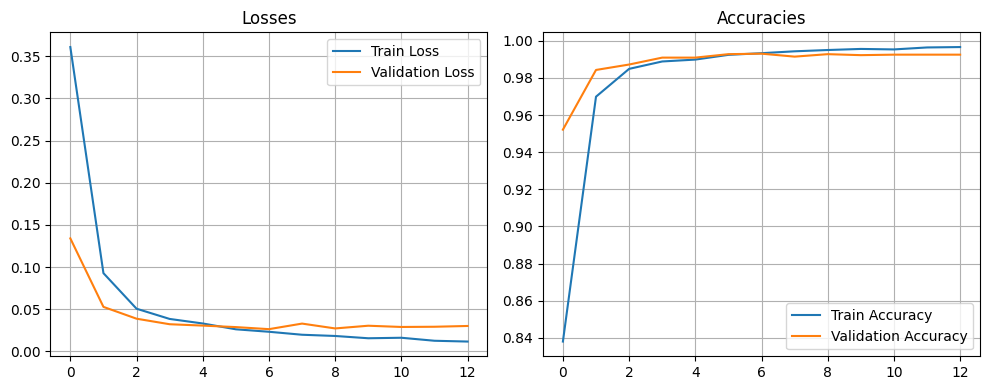

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(val_losses, label='Validation Loss')
axs[0].set_title('Losses')
axs[0].grid('on')
axs[0].legend(loc='best')

axs[1].plot(train_accuracies, label='Train Accuracy')
axs[1].plot(val_accuracies, label='Validation Accuracy')
axs[1].set_title('Accuracies')
axs[1].grid('on')
axs[1].legend(loc='best')

plt.tight_layout();

In [79]:
train_loss, train_acc = evaluate(model, train_loader, device=device)
val_loss, val_acc = evaluate(model, val_loader, device=device)
test_loss, test_acc = evaluate(model, test_loader, device=device)

print(f"Train loss: {train_loss:.4f}, Train accuracy: {100*train_acc:.2f}%")
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {100*val_acc:.2f}%")
print(f"Test loss: {test_loss:.4f}, Test accuracy: {100*test_acc:.2f}%")

Train loss: 0.0071, Train accuracy: 99.82%
Validation loss: 0.0302, Validation accuracy: 99.26%
Test loss: 0.0309, Test accuracy: 99.24%


### Model's mistakes

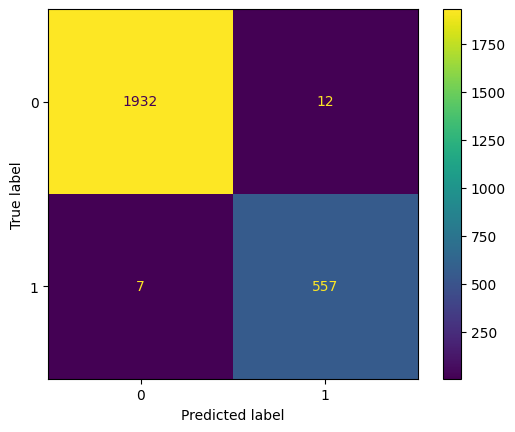

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions, true_labels = predict(model, test_loader)
cm = confusion_matrix(true_labels, predictions, labels=np.unique(true_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(true_labels))
disp.plot()
plt.show()

## Endoder-Decoder based approach

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BartTokenizer, BartModel
import torchsummary as ts

### Load model and encode data

In [29]:
%%capture capt

tokenizer_ae = BartTokenizer.from_pretrained('facebook/bart-base')
model_ae = BartModel.from_pretrained('facebook/bart-base')

In [30]:
batch_size = 512 
MAX_LENGTH = 10

encoded_data = np.zeros((len(X_str), MAX_LENGTH, 768))

for batch in tqdm(range(len(X_str)//batch_size+1)):
    start_index = batch_size*batch
    end_index = start_index + batch_size
    data_batch = list(X_str[start_index:end_index])
    
    inputs = tokenizer_ae(data_batch, return_tensors="pt", padding="max_length", max_length=MAX_LENGTH, truncation=True)
    outputs = model_ae(**inputs)
    encoded_data_batch = outputs.last_hidden_state.cpu().detach().numpy()
    encoded_data[start_index:end_index] = encoded_data_batch
    
encoded_data = encoded_data.reshape(-1, 768*MAX_LENGTH)

100%|██████████| 49/49 [04:04<00:00,  4.99s/it]


### Define classification head

In [31]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [32]:
# Define the MLP classification head
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1, dropout_prob=0.3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.clf = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.clf(x)
        return x

### Create model

In [44]:
input_size = 768*MAX_LENGTH
hidden_size1 = 32
hidden_size2 = 16
output_size = 1
dropout_prob = 0.5

clf_ae = MLP(input_size, hidden_size1, hidden_size2, output_size=output_size, dropout_prob=dropout_prob)
criterion = nn.BCEWithLogitsLoss(reduction='sum')
optimizer_ae = optim.Adam(clf_ae.parameters(), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training running on {"cuda" if torch.cuda.is_available() else "cpu"}')
clf_ae = clf_ae.to(device)

Training running on cuda


In [45]:
ts.summary(clf_ae, (768*MAX_LENGTH,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]         245,792
       BatchNorm1d-2                   [-1, 32]              64
              ReLU-3                   [-1, 32]               0
           Dropout-4                   [-1, 32]               0
            Linear-5                   [-1, 16]             528
       BatchNorm1d-6                   [-1, 16]              32
              ReLU-7                   [-1, 16]               0
           Dropout-8                   [-1, 16]               0
            Linear-9                    [-1, 1]              17
Total params: 246,433
Trainable params: 246,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.94
Estimated Total Size (MB): 0.97
-------------------------------------------

In [36]:
X_train_ae, X_test_ae, y_train_ae, y_test_ae = train_test_split(encoded_data, np.array(y), test_size=0.25, stratify=np.array(y))
X_val_ae, X_test_ae, y_val_ae, y_test_ae = train_test_split(X_test_ae, y_test_ae, test_size=0.4, stratify=y_test_ae)

batch_size = 256

train_dataset_ae = CustomDataset(X_train_ae, y_train_ae)
train_loader_ae = DataLoader(train_dataset_ae, batch_size=batch_size, shuffle=True)

val_dataset_ae = CustomDataset(X_val_ae, y_val_ae)
val_loader_ae = DataLoader(val_dataset_ae, batch_size=batch_size, shuffle=False)

test_dataset_ae = CustomDataset(X_test_ae, y_test_ae)
test_loader_ae = DataLoader(test_dataset_ae, batch_size=batch_size, shuffle=False)

### Training functions

In [37]:
def evaluate_clf_head(model, criterion, loader, device=device):
    model.eval()

    accuracy = 0
    total_loss = 0.
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()
            outputs = model(inputs).squeeze()
            ### ACCURACY ###
            preds = (nn.Sigmoid()(outputs) > 0.5)
            accuracy += (preds == labels).sum().item()
            ### LOSS ###
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    accuracy /= len(loader.dataset)
    total_loss /= len(loader.dataset)
    return total_loss, accuracy

In [38]:
def run_epoch_ae(model, criterion, optimizer, epoch, train_loader, device=device):
    model.train()
    total_loss = 0.
    accuracy =0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()
        outputs = model(inputs).squeeze()
        ### ACCURACY ###
        preds = (nn.Sigmoid()(outputs) > 0.5)
        accuracy += (preds == labels).sum().item()
        ### LOSS ###
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(train_loader.dataset)
    accuracy /= len(train_loader.dataset)
    return total_loss, accuracy

In [39]:
def train_ae(model, train_loader, val_loader, optimizer, criterion, n_epochs, patience, print_every=1, device=device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    min_val_loss = np.inf
    patience_counter = 0
    for epoch in range(n_epochs):
        train_loss, train_accuracy = run_epoch_ae(model, criterion, optimizer, epoch, train_loader, device=device)
        val_loss, val_accuracy = evaluate_clf_head(model, criterion, val_loader, device=device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        #clear_output(wait=False)
        if (print_every != -1) and (epoch % print_every == 0):
            print(f"Epoch {epoch}, Train loss: {train_loss:.4f}, Train acc: {train_accuracy:.3f}, Val loss: {val_loss:.4f}, Val acc: {val_accuracy:.3f}")

        ### PATIENCE ###
        if val_loss <= min_val_loss:
            min_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"##### Epoch {epoch} -> PATIENCE TRIGGERED #####")
                break
    return train_losses, train_accuracies, val_losses, val_accuracies

### Train MLP classification head

In [46]:
n_epochs = 2000
patience = 10
print_every = 10

In [47]:
train_losses_ae, train_accuracies_ae, val_losses_ae, val_accuracies_ae = train_ae(clf_ae, 
                                                                        train_loader_ae, val_loader_ae, optimizer_ae, criterion, 
                                                                        n_epochs, patience, print_every=print_every, device=device)

Epoch 0, Train loss: 0.5859, Train acc: 0.696, Val loss: 0.5373, Val acc: 0.870
Epoch 10, Train loss: 0.4184, Train acc: 0.877, Val loss: 0.4116, Val acc: 0.907
Epoch 20, Train loss: 0.3528, Train acc: 0.901, Val loss: 0.3456, Val acc: 0.914
Epoch 30, Train loss: 0.3006, Train acc: 0.917, Val loss: 0.2862, Val acc: 0.920
Epoch 40, Train loss: 0.2595, Train acc: 0.927, Val loss: 0.2506, Val acc: 0.923
Epoch 50, Train loss: 0.2264, Train acc: 0.936, Val loss: 0.2299, Val acc: 0.925
Epoch 60, Train loss: 0.2054, Train acc: 0.938, Val loss: 0.2179, Val acc: 0.924
Epoch 70, Train loss: 0.1831, Train acc: 0.944, Val loss: 0.2129, Val acc: 0.924
Epoch 80, Train loss: 0.1697, Train acc: 0.946, Val loss: 0.2094, Val acc: 0.923
Epoch 90, Train loss: 0.1547, Train acc: 0.942, Val loss: 0.2064, Val acc: 0.922
Epoch 100, Train loss: 0.1482, Train acc: 0.942, Val loss: 0.2100, Val acc: 0.921
##### Epoch 101 -> PATIENCE TRIGGERED #####


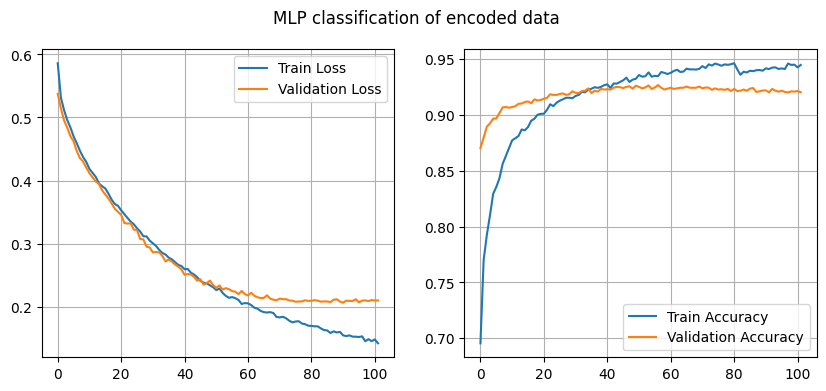

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(train_losses_ae, label='Train Loss')
axs[0].plot(val_losses_ae, label='Validation Loss')
axs[0].grid('on')
axs[0].legend(loc='best')

axs[1].plot(train_accuracies_ae, label='Train Accuracy')
axs[1].plot(val_accuracies_ae, label='Validation Accuracy')
axs[1].grid('on')
axs[1].legend(loc='best')

plt.suptitle('MLP classification of encoded data');

In [49]:
train_loss_ae, train_acc_ae = evaluate_clf_head(clf_ae, criterion, train_loader_ae, device=device)
val_loss_ae, val_acc_ae = evaluate_clf_head(clf_ae, criterion, val_loader_ae, device=device)
test_loss_ae, test_acc_ae = evaluate_clf_head(clf_ae, criterion,  test_loader_ae, device=device)


print(f"Train loss: {train_loss_ae:.4f}, Train accuracy: {100*train_acc_ae:.2f}%")
print(f"Validation loss: {val_loss_ae:.4f}, Validation accuracy: {100*val_acc_ae:.2f}%")
print(f"Test loss: {test_loss_ae:.4f}, Test accuracy: {100*test_acc_ae:.2f}%")

Train loss: 0.1006, Train accuracy: 96.59%
Validation loss: 0.2099, Validation accuracy: 92.02%
Test loss: 0.2144, Test accuracy: 92.19%


### Train Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=150, max_depth=10, n_jobs=-1)
clf_rf.fit(np.concatenate((X_train_ae, X_val_ae)), np.concatenate((y_train_ae, y_val_ae)))

RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1)

In [61]:
print('Ranfom Forest')
print(f"Train accuracy: {clf_rf.score(np.concatenate((X_train_ae, X_val_ae)), np.concatenate((y_train_ae, y_val_ae))):.4f}")
print(f"Test accuracy: {clf_rf.score(X_test_ae, y_test_ae):.4f}")
print()
print(f'Train CE loss = {log_loss(np.concatenate((y_train_ae, y_val_ae)), clf_rf.predict_proba(np.concatenate((X_train_ae, X_val_ae)))):.4f}')
print(f'Test CE loss = {log_loss(y_test_ae, clf_rf.predict_proba(X_test_ae)):.4f}')

Ranfom Forest
Train accuracy: 0.9439
Test accuracy: 0.9011

Train CE loss = 0.1689
Test CE loss = 0.2503


### Train Gradient Boosting method

In [55]:
clg_gb = HistGradientBoostingClassifier(max_iter=10_000, early_stopping=True, class_weight='balanced', validation_fraction=0.2,
                                       l2_regularization=0.0, learning_rate=0.1, max_depth=20, max_leaf_nodes=31, min_samples_leaf=10)
clg_gb.fit(np.concatenate((X_train_ae, X_val_ae)), np.concatenate((y_train_ae, y_val_ae)))

HistGradientBoostingClassifier(class_weight='balanced', early_stopping=True,
                               max_depth=20, max_iter=10000,
                               min_samples_leaf=10, validation_fraction=0.2)

In [62]:
print("Tree Gradient Boosting")
print(f"Train accuracy: {clg_gb.score(np.concatenate((X_train_ae, X_val_ae)), np.concatenate((y_train_ae, y_val_ae))):.4f}")
print(f"Test accuracy: {clg_gb.score(X_test_ae, y_test_ae):.4f}")
print()
print(f'Train CE loss = {log_loss(np.concatenate((y_train_ae, y_val_ae)), clg_gb.predict_proba(np.concatenate((X_train_ae, X_val_ae)))):.4f}')
print(f'Test CE loss = {log_loss(y_test_ae, clg_gb.predict_proba(X_test_ae)):.4f}')

Tree Gradient Boosting
Train accuracy: 0.9632
Test accuracy: 0.9187

Train CE loss = 0.1050
Test CE loss = 0.2250


### Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(n_jobs=-1, class_weight='balanced', max_iter=5000)
clf_lr.fit(np.concatenate((X_train_ae, X_val_ae)), np.concatenate((y_train_ae, y_val_ae)))

LogisticRegression(class_weight='balanced', max_iter=5000, n_jobs=-1)

In [66]:
print("Logistic Regression")
print(f"Train accuracy: {clf_lr.score(np.concatenate((X_train_ae, X_val_ae)), np.concatenate((y_train_ae, y_val_ae))):.4f}")
print(f"Test accuracy: {clf_lr.score(X_test_ae, y_test_ae):.4f}")
print()
print(f'Train CE loss = {log_loss(np.concatenate((y_train_ae, y_val_ae)), clf_lr.predict_proba(np.concatenate((X_train_ae, X_val_ae)))):.4f}')
print(f'Test CE loss = {log_loss(y_test_ae, clf_lr.predict_proba(X_test_ae)):.4f}')

Logistic Regression
Train accuracy: 0.9882
Test accuracy: 0.9039

Train CE loss = 0.0336
Test CE loss = 0.6434
